In [1]:
import os

import torch as t
import numpy as np
import einops
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
import pickle

from circuits.dictionary_learning.buffer import NNsightActivationBuffer
from circuits.dictionary_learning.dictionary import AutoEncoder, AutoEncoderNew, GatedAutoEncoder
import circuits.othello_utils as othello_utils
from circuits.utils import (
    othello_hf_dataset_to_generator,
    get_model,
    get_submodule,
)

import circuits.analysis as analysis
import circuits.utils as utils
import circuits.othello_utils as othello_utils
import circuits.chess_utils as chess_utils

repo_dir = "/home/adam/chess-gpt-circuits/"
# repo_dir = '/share/u/can/chess-gpt-circuits'
device = 'cuda:0'

othello = True

In [2]:
if othello:
    # download data from huggingface if needed
    if not os.path.exists(f'{repo_dir}/autoencoders/othello_5-21'):
        hf_hub_download(repo_id='adamkarvonen/othello_saes', filename='othello_5-21.zip', local_dir=f'{repo_dir}/autoencoders')
        # unzip the data
        os.system(f'unzip {repo_dir}/autoencoders/othello_5-21.zip -d autoencoders')

In [3]:
# load SAE
ae_type = 'p_anneal'
trainer_id = 4

if othello:
    ae_path = f'{repo_dir}/autoencoders/othello_5-21/othello-{ae_type}/trainer{trainer_id}'
else:
    ae_path = f'{repo_dir}/autoencoders/chess-trained_model-layer_5-2024-05-23/chess-trained_model-layer_5-{ae_type}/trainer{trainer_id}'


if ae_type == 'standard' or ae_type == 'p_anneal':
    ae = AutoEncoder.from_pretrained(os.path.join(ae_path, 'ae.pt'), device='cuda:0')
elif ae_type == 'gated' or ae_type == 'gated_anneal':
    ae = GatedAutoEncoder.from_pretrained(os.path.join(ae_path, 'ae.pt'), device='cuda:0')
elif ae_type == 'standard_new':
    ae = AutoEncoderNew.from_pretrained(os.path.join(ae_path, 'ae.pt'), device='cuda:0')
else:
    raise ValueError('Invalid ae_type')

print(ae.encoder.weight.shape)
ae_hidden_dim = ae.encoder.weight.shape[0]
d_model = ae.encoder.weight.shape[1]

torch.Size([4096, 512])


In [4]:
# load model
d_model = 512  # output dimension of the layer
layer = 5

if not othello:
    with open("models/meta.pkl", "rb") as f:
        meta = pickle.load(f)

    context_length = 256
    model_name = "adamkarvonen/8LayerChessGPT2"
    dataset_name = "adamkarvonen/chess_sae_text"
    data = utils.chess_hf_dataset_to_generator(
        dataset_name, meta, context_length=context_length, split="train", streaming=True
    )
    model_type = "chess"
else:
    context_length = 59
    model_name = "Baidicoot/Othello-GPT-Transformer-Lens"
    dataset_name = "taufeeque/othellogpt"
    data = utils.othello_hf_dataset_to_generator(
        dataset_name, context_length=context_length, split="train", streaming=True
    )
    model_type = "othello"

model = utils.get_model(model_name, device)
submodule = utils.get_submodule(model_name, layer, model)

mlp_post_submodules = [model.blocks[layer].mlp.hook_post for layer in range(model.cfg.n_layers)]

batch_size = 8
total_games_size = batch_size * 10

buffer = NNsightActivationBuffer(
    data,
    model,
    submodule,
    n_ctxs=8e3,
    ctx_len=context_length,
    refresh_batch_size=batch_size,
    io="out",
    d_submodule=d_model,
    device=device,
)

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Loaded pretrained model Baidicoot/Othello-GPT-Transformer-Lens into HookedTransformer
Moving model to device:  cuda:0


## Single SAE feature ~ all MLP neurons
Fixing a single SAE feature, which MLP neurons (in earlier and later layers) show high pearson correlation with the SAE feature?

From feature viz notebook: Feature #21 of f'{repo_dir}/autoencoders/group-2024-05-17_othello/group-2024-05-17_othello-{standard_new}/trainer{0}' looks like it is representing a piece on H1 or G1

<img src="./feat21.png" alt="Image description" width="800"/>

In [5]:
feat_idx = 21

In [7]:
# Caching activations with nnsight
mlp_acts_bLF = {}
for layer in range(model.cfg.n_layers):
    mlp_acts_bLF[layer] = t.zeros((total_games_size, context_length, d_model * 4), dtype=t.float32, device=device)

tokens_bL = t.zeros((total_games_size, context_length), dtype=t.int16, device=device)
feature_activations_bLF = t.zeros((total_games_size, context_length, ae_hidden_dim), dtype=t.float32, device=device)

for i in range(0, total_games_size, batch_size):
    game_batch_BL = [next(data) for _ in range(batch_size)]
    game_batch_BL = t.tensor(game_batch_BL, device=device)
    with t.no_grad(), model.trace(game_batch_BL, scan=False, validate=False):
        x_BLD = submodule.output
        feature_acts_BLF = ae.encode(x_BLD).save()
        for layer in range(model.cfg.n_layers):
            mlp_acts_bLF[layer][i:i+batch_size] = mlp_post_submodules[layer].output.save()
    tokens_bL[i:i+batch_size] = game_batch_BL
    feature_activations_bLF[i:i+batch_size] = feature_acts_BLF

feature_activations_Fb = einops.rearrange(feature_activations_bLF, "B S F -> F (B S)")

for layer in mlp_acts_bLF:
    mlp_acts_bLF[layer] = einops.rearrange(mlp_acts_bLF[layer], "B S F -> F (B S)")
mlp_acts_Fb = {layer: mlp_acts_bLF[layer] for layer in mlp_acts_bLF}

In [14]:
# Pearson correlation calculation function
def pearson_corr(x, y):
    mean_x = x.mean(dim=-1, keepdim=True)
    mean_y = y.mean(dim=-1, keepdim=True)
    xm = x - mean_x
    ym = y - mean_y
    r_num = t.sum(xm * ym, dim=-1)
    r_den = t.sqrt(t.sum(xm * xm, dim=-1) * t.sum(ym * ym, dim=-1))
    
    with t.no_grad():
        zero_variance = (r_den == 0)
    r = t.where(zero_variance, t.zeros_like(r_num), r_num / r_den)

    return r


def get_correlation_for_activation(
    x_activations_Fb: t.Tensor, x_activation_index: int, y_activations_Fb: t.Tensor
) -> t.Tensor:
    x_activation_b = x_activations_Fb[x_activation_index]
    correlations = t.zeros(y_activations_Fb.shape[0])

    for i in range(y_activations_Fb.shape[0]):
        y_activation_b = y_activations_Fb[i]
        corr = pearson_corr(x_activation_b, y_activation_b)
        correlations[i] = corr

    return correlations

mlp_neuron_idx = 1024
# correlations = get_correlation_for_activation(feature_activations_Fb, feat_idx, mlp_acts_Fb[5])
correlations = get_correlation_for_activation(mlp_acts_Fb[5], mlp_neuron_idx, feature_activations_Fb)

# Calculate Pearson correlation
# pearson_correlations = {}

# for layer in mlp_acts:
#     mlp_acts_layer = mlp_acts[layer]
#     correlations = t.zeros(mlp_acts_layer.shape[0])
#     for i in range(mlp_acts_layer.shape[0]):
#         mlp_feature = mlp_acts_layer[i]
#         corr = pearson_corr(feature_acts_BLF, mlp_feature)
#         correlations[i] = corr
#     pearson_correlations[layer] = correlations

torch.Size([4096])
tensor(0.5275)
tensor(3098)


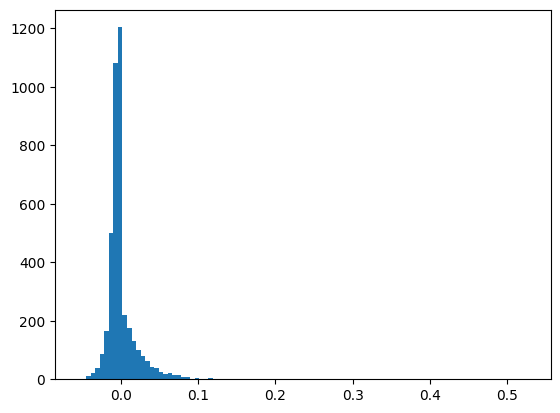

In [16]:
print(correlations.shape)
print(correlations.max())
print(correlations.argmax())

plt.hist(correlations.cpu().numpy(), bins=100)
plt.show()

In [ ]:
# # Prepare data
# layers = list(pearson_correlations.keys())
# data = [pearson_correlations[l].abs() for l in layers]

# # Create stacked histogram
# plt.hist(data, bins=100, histtype='bar', stacked=True, label=layers)

# # Add legend and log scale for y-axis
# plt.legend(title='Layer')
# plt.yscale('log')

# # Display plot
# plt.xlabel('Absolute Pearson Correlation')
# plt.ylabel('Frequency')
# plt.title('Stacked Histogram of Pearson Correlations by Layer')
# plt.show()

In [ ]:
# # save indices and layer for pearson_correlations above a certain threshold
# corr_threshold = 0.5
# indices = {}
# for layer in pearson_correlations:
#     indices[layer] = t.where(pearson_correlations[layer].abs() > corr_threshold)[0]

# indices